In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
import fastai
from fastai.imports import *

from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/apps/software/standard/core/anaconda3/5.2.0/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = "/scratch/kk4ze/data_lowres_augmented/"
sz=2200

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['models', 'tmp', 'valid', 'train']

In [7]:
files = os.listdir(f'{PATH}valid/Celiac')[:5]
files

['C07-37_06_8055_8580_vert__0.jpg',
 'C04-19_03_10858_6377_horiz__1.jpg',
 'C17-80_01_14732_17747_vert__0.jpg',
 'C06-33_02_8189_5011_horiz__0.jpg',
 'C06-30_04_9949_8871_horiz__0.jpg']

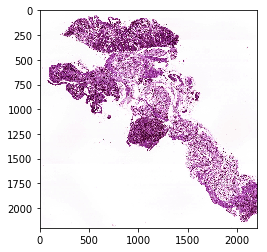

In [8]:
img = plt.imread(f'{PATH}valid/Celiac/{files[4]}')
plt.imshow(img);

In [9]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),bs=2)


In [10]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [22]:
learn.fit(0.001, 8)

epoch      trn_loss   val_loss   accuracy                     
    0      0.905491   0.517871   0.820652  
    1      0.733968   0.467721   0.820652                     
    2      0.611666   0.444573   0.858696                    
    3      0.619481   0.428117   0.809783                     
    4      0.569827   0.426365   0.842391                     
    5      0.524585   0.410752   0.847826                     
    6      0.554463   0.466045   0.815217                     
    7      0.54531    0.416867   0.820652                     



[0.4168671985035357, 0.8206521739130435]

## Visualising Results

In [13]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
# from here we know that 'Celiac' is label 0 and 'EE' is label 1 and 'Normal' is label 2
data.classes

['Celiac', 'EE', 'Normal']

In [15]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(184, 3)

Most Correct Celiac


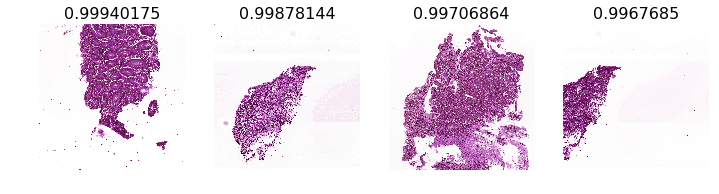

In [16]:
imr = ImageModelResults(data.val_ds, log_preds)
print('Most Correct Celiac')
imr.plot_most_correct(0)

Most Correct EE


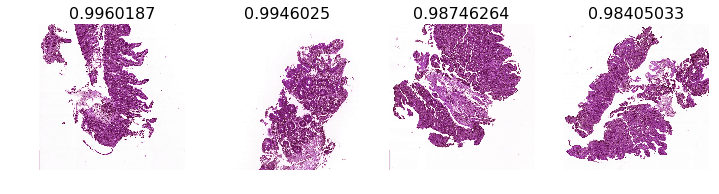

In [17]:
print('Most Correct EE')
imr.plot_most_correct(1)

In [ ]:
print('Most Correct Normal')
imr.plot_most_correct(2)

In [ ]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

In [ ]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

In [ ]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
y = data.val_y

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

## Finding a optimum learning rate

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [13]:
lrf=learn.lr_find()

 49%|████▉     | 93/189 [00:00<00:00, 441.59it/s, loss=1.21]


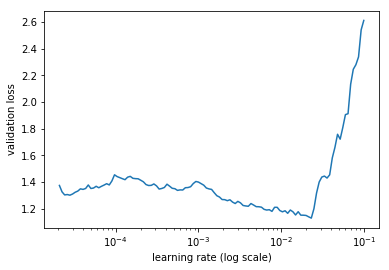

In [14]:
learn.sched.plot()

## Data Augmentation

In [11]:
# Using predefined augmentations transforms_top_down
tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

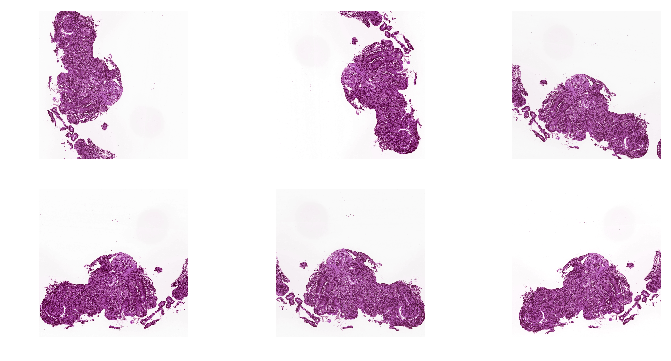

In [12]:
# Visualising the augmentation
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [13]:
# Initializing the data with augmentation and learn method
data = ImageClassifierData.from_paths(PATH, tfms=tfms,bs=4)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.precompute = False

In [18]:
lrf=learn.lr_find()

 70%|██████▉   | 132/189 [01:42<00:36,  1.58it/s, loss=4.56]

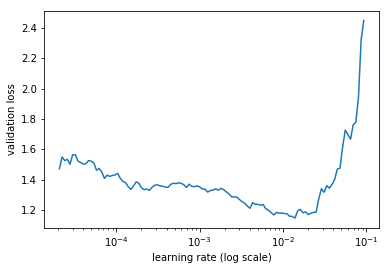

In [19]:
learn.sched.plot()

In [20]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.300695   0.750254   0.728261  
    1      1.625155   0.887902   0.75                       
    2      1.525388   0.736812   0.76087                    


[0.7368115750343903, 0.7608695652173914]

In [ ]:
learn.save('256_lastlayer_resnet50_duplicates_staintools')

In [ ]:
learn.load('256_lastlayer_resnet50_duplicates_staintools')

## Unfreezing layers and using Differential learning rates

In [14]:
# Unfreeze all layers for training
learn.unfreeze()

In [15]:
lrf=learn.lr_find()

  0%|          | 0/189 [00:00<?, ?it/s]


RuntimeError: CUDA error: out of memory

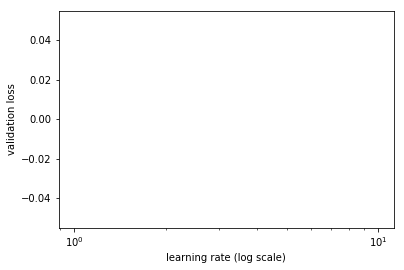

In [26]:
learn.sched.plot()

In [15]:
lr = (1e-2 + 1e-3)/2

In [16]:
lr=np.array([lr/9,lr/3,lr])

In [18]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

  0%|          | 0/189 [00:00<?, ?it/s]


RuntimeError: CUDA error: out of memory

In [21]:
learn.save('2200_lowres_resnet34_staintools')

In [14]:
learn.load('2200_lowres_resnet34_staintools')

NameError: name 'learn' is not defined

## Analyzing results

### Confusion Matrix and Accuracy with Test Time Augmentation

In [22]:
# Getting log predictions with TTA
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.7989130434782609

In [23]:
log_preds.shape

(5, 184, 3)

In [ ]:
np.save('/scratch/kk4ze/data_lowres_augmented/logpreds_resnet50_all_layers256x256_duplicates_TTA_staintools.npy', log_preds)

In [42]:
log_preds = np.load('/scratch/kk4ze/data_lowres_augmented/logpreds_resnet50_all_layers256x256_duplicates_TTA_staintools.npy')

In [43]:
log_preds_mean = np.mean(log_preds, 0)

In [20]:
preds = np.argmax(probs, axis=1)

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[53698   149  5089]
 [  591 51110    83]
 [ 6612    13 41039]]


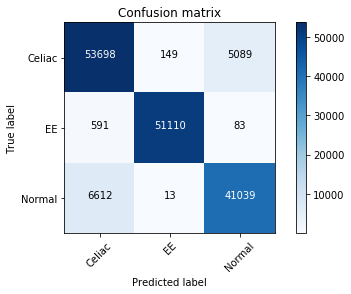

In [22]:
plot_confusion_matrix(cm, data.classes)

### Visualizing results with TTA

Most Correct Celiac


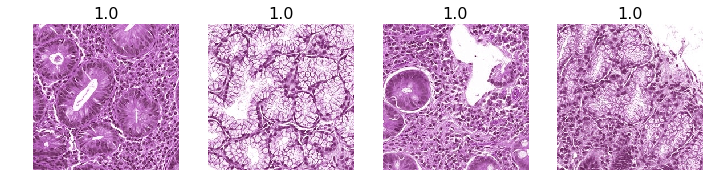

In [23]:
imr = ImageModelResults(data.val_ds, log_preds_mean)
print('Most Correct Celiac')
imr.plot_most_correct(0)

Most Correct EE


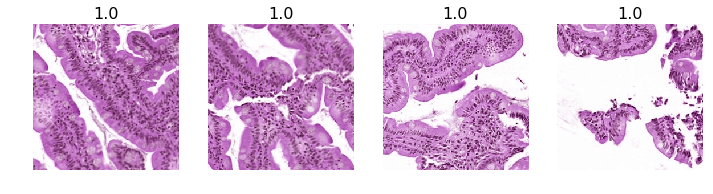

In [24]:
print('Most Correct EE')
imr.plot_most_correct(1)

Most Correct Noraml


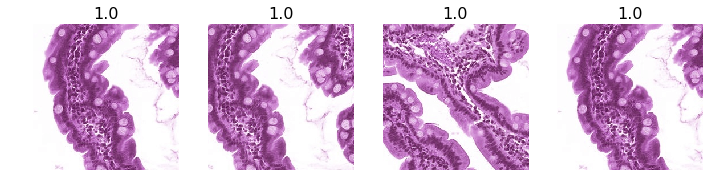

In [25]:
print('Most Correct Noraml')
imr.plot_most_correct(2)

Most Incorrect Celiac


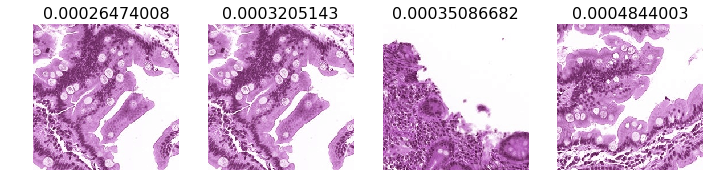

In [26]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

Most Incorrect EE


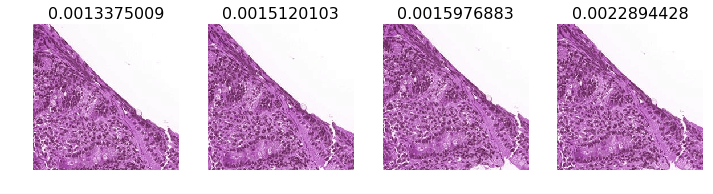

In [27]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

Most Incorrect Normal


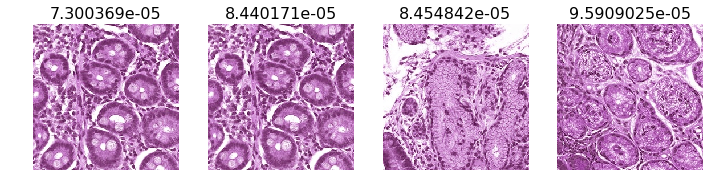

In [28]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

Most Uncertain Celiac


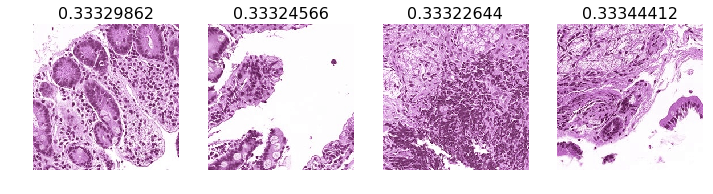

In [29]:
print('Most Uncertain Celiac')
imr.plot_most_uncertain(0)

Most Uncertain EE


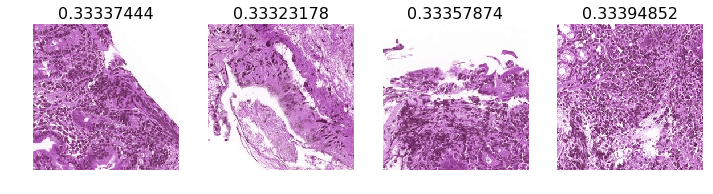

In [30]:
print('Most Uncertain EE')
imr.plot_most_uncertain(1)

Most Uncertain Normal


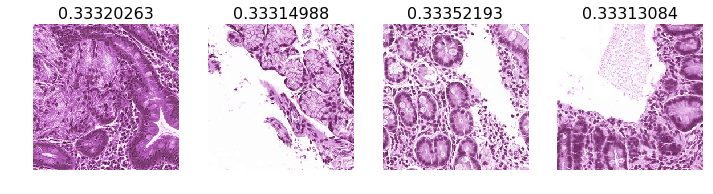

In [31]:
print('Most Uncertain Normal')
imr.plot_most_uncertain(2)

### Confusion Matrix and Accuracy without Test Time Augmentation

In [ ]:
# Getting log predictions without TTA
log_preds = learn.predict()

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

## Saving predictions of the model with TTA

In [45]:
np.exp(log_preds_mean)

array([[0.17136, 0.00017, 0.39814],
       [0.99999, 0.     , 0.     ],
       [0.99952, 0.00002, 0.00011],
       ...,
       [0.00143, 0.     , 0.99724],
       [0.03098, 0.00019, 0.91937],
       [0.1621 , 0.00007, 0.78512]], dtype=float32)

In [46]:
res = pd.DataFrame(np.exp(log_preds_mean))

In [47]:
res['file'] = data.val_ds.fnames

In [48]:
res.columns = ['Celiac', 'EE', 'Normal', 'FileName']

In [49]:
res.to_csv('../results/preds_resnet50_256_duplicates_TTA_staintools.csv')

In [50]:
res.head()

,Celiac,EE,Normal,FileName
0,0.171363,0.000166,0.398144,valid/Celiac/C16-77_02_3330_999_1.jpg
1,0.999991,0.000002,0.000004,valid/Celiac/C06-27_02_5994_4662_0.jpg
2,0.999517,0.000018,0.000107,valid/Celiac/C06-28_02_13653_666_1.jpg
3,0.999978,0.000009,0.000002,valid/Celiac/C06-28_02_13320_1332_1.jpg
4,0.999983,0.000009,0.000004,valid/Celiac/C06-32_02_5994_2664_0.jpg
